In [282]:
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt
from pathlib import Path
import os
import re

In [283]:
# Path del código.
CODE_PATH = Path(__file__).parent if '__file__' in globals() else Path(os.getcwd())

# Path del excel.
EXCEL_PATH = CODE_PATH / 'Periods.xlsx'

In [284]:
def Make_Day_Column(df: pd.DataFrame, Datetime_Column: str, Day_Column_Name: str = 'Día') -> pd.DataFrame:

    """
    Adds a new column with the day extracted from the specified datetime column.
    The new column is placed as the first column of the DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    Datetime_Column (str): The column name that contains datetime values.
    Day_Column_Name (str): The name of the new column that will contain the day values.

    Returns:
    pd.DataFrame: The modified DataFrame with the new day column as the first column.

    """
    
    Days = [] 

    for Index, Row in df.iterrows():
        Day_Value = re.search(r'\d{4}-\d{2}-\d{2}', str(Row[Datetime_Column]))
        Days.append(Day_Value.group() if Day_Value else None)
    
    df[Day_Column_Name] = Days
    Columns_Order = [Day_Column_Name] + [Column for Column in df.columns if Column != Day_Column_Name]
    df = df[Columns_Order]

    return df

In [285]:
def Make_Interval(df: pd.DataFrame, Start_Column: str, End_Column: str, 
                  Interval_Column_Name: str = 'Intervalo') -> pd.DataFrame:
    
    Intervals = [] 

    for Index, Row in df.iterrows():
        Start_Value = re.search(r'\d{2}:\d{2}', str(Row[Start_Column]))
        End_Value = re.search(r'\d{2}:\d{2}', str(Row[End_Column]))
        Intervals.append(f'{Start_Value.group()} - {End_Value.group()}' if Start_Value else None)
    
    df[Interval_Column_Name] = Intervals
    df = df.drop(columns=['Inicio', 'Final'])
    Columns_Order = ['Día'] + [Interval_Column_Name] + [Column for Column in df.columns if Column not in ['Día', Interval_Column_Name]]
    df = df[Columns_Order]

    return df

In [286]:
def Make_Categories(df: pd.DataFrame, Task_Column: str, 
                    Categories_Column_Name: str = 'Categoría',
                    Tasks_Column_Name: str = 'Tarea') -> pd.DataFrame:
    
    """
    Splits a column of tasks into two parts: category and task. The category is extracted as the 
    text before the first period, and the task is the text after the first period, including spaces.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    Task_Column (str): The column name that contains task descriptions.
    Categories_Column_Name (str): The name of the new column for categories. Default is 'Categoría'.
    Tasks_Column_Name (str): The name of the new column for tasks. Default is 'Tarea'.

    Returns:
    pd.DataFrame: The modified DataFrame with the new categories and tasks columns.

    """
    
    Categories = []  
    Tasks = []       

    for Index, Row in df.iterrows():
        Category = re.search(r'^[^.]+', str(Row[Task_Column]))  # Match everything before the first period.
        Categories.append(Category.group().strip() if Category else None)

        Task = re.search(r'(?<=\.).+', str(Row[Task_Column]))  # Match everything after the first period.
        Tasks.append(Task.group().strip() if Task else None)
    
    df[Categories_Column_Name], df[Tasks_Column_Name] = Categories, Tasks
    
    df = df.drop(columns=['Plan_Previsto', 'Explicación'])
    
    Columns_Order = ['Día', 'Intervalo'] + [Categories_Column_Name, Tasks_Column_Name] + [Column for Column in df.columns if Column not in ['Día', 'Intervalo', Categories_Column_Name, Tasks_Column_Name]]
    df = df[Columns_Order]

    return df

In [287]:
def Make_Block_Bar_Plot(df, Column, Lenght_Interval = 10, Y_Axis = 'Horas'):

    # In Blocks.
    Timespent_By_Category = df[Column].value_counts()

    if Y_Axis != 'Bloques':
        # In Minutes.
        Timespent_By_Category = Timespent_By_Category * Lenght_Interval

        if Y_Axis == 'Horas':
            # In Hours.
            Timespent_By_Category = Timespent_By_Category / 60


    # Crear la figura y los ejes.
    Figure, Graphic_1 = plt.subplots(figsize=(10, 6))

    # Dibujar el gráfico de barras.
    Bars = Graphic_1.bar(Timespent_By_Category.index, Timespent_By_Category.values, width=0.8)

    # Agregar etiquetas y título.
    Graphic_1.set_ylabel(Y_Axis)

    # Convertir las horas decimales a horas y redondear los minutos al múltiplo más cercano de 10.
    Labels = [f'{int(Value)}:{round((Value % 1) * 60 / 10) * 10:02d}' for Value in Timespent_By_Category.values]
    
    # Agregar las etiquetas de horas y minutos sobre las barras.
    Graphic_1.bar_label(Graphic_1.containers[0], labels=Labels, fontsize=8)

    # Mostrar el gráfico.
    plt.show()

In [288]:
def Filter_And_Plot_By_Date(df: pd.DataFrame, Date_Column: str, Start_Date: str, End_Date: str, 
                            Plot_Column: str, Lenght_Interval: int = 10, Y_Axis: str = 'Horas') -> None:
    
    """
    Filters the DataFrame between two dates and generates a bar plot using the Make_Block_Bar_Plot function.

    Args:
    df (pd.DataFrame): The input DataFrame.
    Date_Column (str): The name of the column containing the dates.
    Start_Date (str): The start date (inclusive) in 'YYYY-MM-DD' format.
    End_Date (str): The end date (inclusive) in 'YYYY-MM-DD' format.
    Plot_Column (str): The column for which the block-based statistics are to be plotted.
    Lenght_Interval (int): The length of each block interval (default is 10).
    Y_Axis (str): The Y-axis label, defaults to 'Horas'. Could be 'Minutos' or 'Bloques'.

    """

    # Convertir la columna de fecha a formato datetime si no lo está.
    df[Date_Column] = pd.to_datetime(df[Date_Column])

    # Filtrar el DataFrame entre las dos fechas.
    df = df[(df[Date_Column] >= Start_Date) & (df[Date_Column] <= End_Date)]

    # Llamar a la función para generar el gráfico de barras.
    Make_Block_Bar_Plot(df, Plot_Column, Lenght_Interval, Y_Axis)

In [289]:
def Plot_Time_Blocks(df, Start_Day, End_Day):
    Blocks = Make_Day_Column(df, 'Inicio')
    Blocks = Make_Day_Column(Blocks, 'Inicio')
    Blocks = Make_Interval(Blocks, 'Inicio', 'Final')
    Blocks = Make_Categories(Blocks, 'Plan_Previsto')
    Filter_And_Plot_By_Date(Blocks, 'Día', Start_Day, End_Day, 'Categoría')

In [290]:
def Get_Time_Blocks(df, Period = 'Week', Start_Day = False, End_Day = False):

    Year = dt.datetime.now().year
    Month = dt.datetime.now().month
    Weekday = dt.datetime.now().weekday()
    Today = dt.datetime.now().date()

    First_Day_Year = (Today - dt.timedelta(days = Year)).strftime('%Y-%m-%d') 
    First_Day_Month = (Today - dt.timedelta(days = Month)).strftime('%Y-%m-%d') 
    First_Day_Week = (Today - dt.timedelta(days = Weekday)).strftime('%Y-%m-%d') 

    if isinstance(Period, int):
        First_Day = (Today - dt.timedelta(days = Period)).strftime('%Y-%m-%d')
        
    Today = Today.strftime('%Y-%m-%d') 

    if Period == 'Year':
        print('Inicio:', First_Day_Year)
        print('Final:', Today)
        Plot_Time_Blocks(df, First_Day_Year, Today)
    elif Period == 'Month':
        print('Inicio:', First_Day_Month)
        print('Final:', Today)
        Plot_Time_Blocks(df, First_Day_Month, Today)
    elif Period == 'Week':
        print('Inicio:', First_Day_Week)
        print('Final:', Today)
        Plot_Time_Blocks(df, First_Day_Week, Today)
    elif Period == 'Today':
        print('Inicio:', Today)
        print('Final:', Today)
        Plot_Time_Blocks(df, Today, Today)
    elif isinstance(Period, int):
        print('Inicio:', First_Day)
        print('Final:', Today)
        Plot_Time_Blocks(df, First_Day, Today)
    elif Period == 'Period':
        print('Inicio:', Start_Day)
        print('Final:', End_Day)
        Plot_Time_Blocks(df, Start_Day, End_Day)
    else:
        raise KeyError(f"Ingresá: 'Year', 'Month', 'Week' o 'Today'")

In [291]:
# Cargar Periods.xlsx
Blocks = pd.read_excel(EXCEL_PATH)

In [292]:
Period = 'Today'
Start_Day = False
End_Day = False

Inicio: 2024-10-11
Final: 2024-10-11


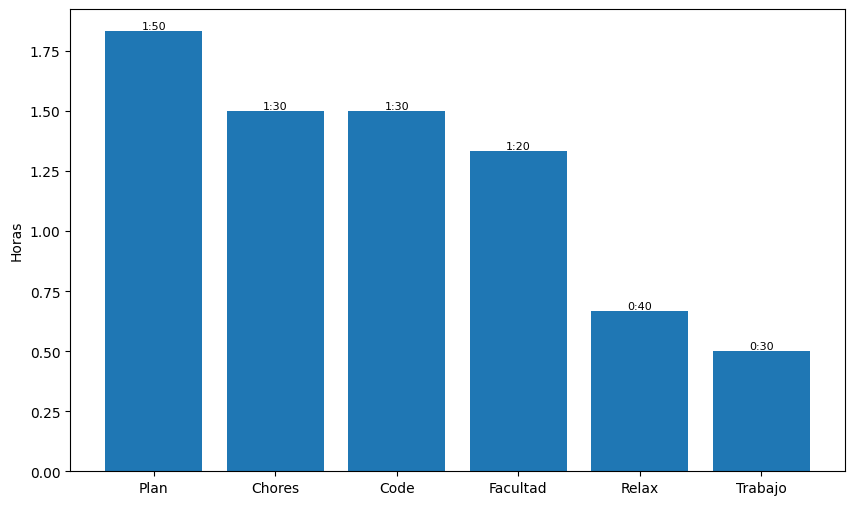

In [293]:
# Plotear.
Get_Time_Blocks(Blocks, Period = Period, Start_Day = Start_Day, End_Day = End_Day)

In [ ]:
# No contabiliza bien: solo contabiliza los planes, no la realidad.
# Gráficos para las tareas en sí y no las categorías.


# Que puedas poner categorías y te pregunte la categoría y la acción específica. Incluso un "Detalle".
# Que puedas definir tus categorías personalizadas, así como las subcategorías.
# Que no se guarden los períodos que no se pone nada. O te pregunte si querés agregarlos en un cartel,
# poniendo qué hiciste. Que permita seleccionar de a bloques "Todos tal cosa".